In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 15b
## Working with PyTorch
- one hidden layer 
- ${tanh}$ activation function
- multi-class output
- FIFA dataset
- Regularization
- Dropout

<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
import os
#import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


In [3]:
# Some basic parameters
inpDir = '../input'
outDir = '../output'

RANDOM_STATE = 24
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 6401 # number of epochs
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.1

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = plt.cm.Spectral

plt.rcParams.update(params)

## Read FIFA 2019 data set

In [4]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [5]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [6]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [7]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [8]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [9]:
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [10]:
labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [11]:
y = data_df["Position"].values

X = data_df.drop("Position", axis = 1)

# one hot encoding
y = pd.get_dummies(y).values
X.shape, y.shape

((18147, 33), (18147, 4))

In [12]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(16332, 33) (16332, 4) (1815, 33) (1815, 4)


In [13]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

## All about CUDA

In [14]:
print ('Is CUDA available: ', torch.cuda.is_available())

print ('CUDA version: ', torch.version.cuda )

print ('Current Device ID: ', torch.cuda.current_device())

print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

Is CUDA available:  True
CUDA version:  11.7
Current Device ID:  0
Name of the CUDA device:  NVIDIA GeForce RTX 3060 Laptop GPU


In [15]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cuda device


In [16]:
class Model(nn.Module):
    
    def __init__(self, input_dim):
        
        super(Model, self).__init__()
        
        self.layer1 = nn.Linear(input_dim,16)
        
        self.dropout = nn.Dropout(0.2)  # implimenting Drop out

        
        self.layer2 = nn.Linear(16, 4)
        
        self.bn = nn.BatchNorm1d(16)  # implementing Batch Normalization
        
    def forward(self, x):
        
        x = F.silu(self.bn(self.layer1(x)))
        
        x = self.dropout(x) # implimenting drop out
        
        x = F.softmax(self.layer2(x), dim=1)
        
        return x

model = Model(X_train.shape[1]).to(device) # Create model on GPU

print (model)

Model(
  (layer1): Linear(in_features=33, out_features=16, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (layer2): Linear(in_features=16, out_features=4, bias=True)
  (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [17]:
list(model.parameters())

[Parameter containing:
 tensor([[ 9.2062e-02, -4.3501e-02, -1.4794e-01,  1.0717e-02,  1.6225e-01,
          -7.7643e-02, -5.6670e-02,  1.3613e-01, -2.4222e-02, -6.6486e-02,
          -3.5062e-02,  6.3746e-03, -1.4182e-01, -4.9749e-02,  1.6879e-01,
          -3.7317e-02,  1.5855e-01, -6.7960e-02, -7.0020e-02, -5.1887e-02,
          -1.5565e-01, -1.0485e-01,  1.0520e-01, -1.3059e-01,  5.9465e-02,
           1.6379e-01, -2.2121e-02,  7.6153e-02,  8.1313e-02, -1.2426e-01,
          -6.7123e-02, -5.4516e-02,  1.6798e-01],
         [-1.5537e-01,  1.0537e-01,  1.6350e-01,  1.3764e-01,  7.4190e-02,
           7.7494e-02, -9.2818e-03,  8.7583e-02,  1.5868e-01, -5.5976e-02,
           1.6820e-01,  2.7665e-02, -1.2210e-01, -1.2494e-01,  6.1399e-02,
          -2.4561e-02, -7.6685e-02,  8.8150e-02, -9.1821e-02, -8.3203e-02,
           3.2539e-02, -3.1431e-02, -1.4688e-01, -5.2295e-02, -6.1178e-02,
          -7.4187e-02,  1.3552e-01, -2.6404e-02, -1.0632e-01,  5.1576e-02,
           2.9993e-02, -1.3

In [18]:
# wrap up with Variable in pytorch and transfer them to GPU

train_X = Variable(torch.Tensor(X_train).float()).to(device) 

test_X = Variable(torch.Tensor(X_test).float()).to(device)

train_y = Variable(torch.Tensor(y_train).float()).to(device)

test_y = Variable(torch.Tensor(y_test).float()).to(device)

In [19]:
loss_fn = nn.CrossEntropyLoss() # cross entropy loss

loss = []
tloss = []
n_epoch = []
acc = []
t_acc = []
 
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=ALPHA, 
                             weight_decay=0.1e-5) # use weight decay for L2 regularization

In [20]:
for epoch in range(EPOCHS):
    
    model.train() # Set model in training mode
    
    # Compute prediction error
    y_pred_tr = model(train_X)
    
    curr_loss = loss_fn(y_pred_tr, train_y)
    
    # Backpropagation
    optimizer.zero_grad() # reset to zero before starting backprop for this epoch 
    
    curr_loss.backward() # using current loss backprop the loss
    
    optimizer.step() # perform a parameter update based on the current gradient
    

    if epoch % 1 == 0:
        
        loss.append(curr_loss.data.item())
        
        predictions  = model(train_X)
        
        _, y_pred = torch.max(predictions, 1)
        
        curr_acc = accuracy_score(y_train.argmax(axis = 1), y_pred.data.cpu())
        
        acc.append (curr_acc)
        
        model.eval() # Set model in evaluation (inference) mode
    
        y_pred_tst = model(test_X)
    
        tcurr_loss = loss_fn(y_pred_tst, test_y)
        
        predictions  = model(test_X)
        
        _, y_pred = torch.max(predictions, 1)
        
        tcurr_acc = accuracy_score(y_test.argmax(axis = 1), y_pred.data.cpu())
        
        t_acc.append (tcurr_acc)

        
        tloss.append(tcurr_loss.data.item())
        
        n_epoch.append(epoch)
    
    if epoch % 100 == 0:
        fmtStr = 'Epoch: {:5d}/{:5d}\nLoss : {:.5f}| Test Loss : {:.5f} | Acc : {:.5f}| Test Acc : {:.5f}\n'
        print (fmtStr.format( epoch, EPOCHS, 
                             curr_loss.data.item(), tcurr_loss.data.item(), 
                             curr_acc, tcurr_acc) ) 

Epoch:     0/ 6401
Loss : 1.41374| Test Loss : 1.39288 | Acc : 0.14475| Test Acc : 0.15427

Epoch:   100/ 6401
Loss : 1.09167| Test Loss : 1.07137 | Acc : 0.78508| Test Acc : 0.80826

Epoch:   200/ 6401
Loss : 0.97134| Test Loss : 0.95321 | Acc : 0.84619| Test Acc : 0.85069

Epoch:   300/ 6401
Loss : 0.92533| Test Loss : 0.91165 | Acc : 0.85666| Test Acc : 0.86556

Epoch:   400/ 6401
Loss : 0.90804| Test Loss : 0.89619 | Acc : 0.85801| Test Acc : 0.86391

Epoch:   500/ 6401
Loss : 0.89959| Test Loss : 0.88865 | Acc : 0.86089| Test Acc : 0.86336

Epoch:   600/ 6401
Loss : 0.89459| Test Loss : 0.88413 | Acc : 0.86229| Test Acc : 0.86336

Epoch:   700/ 6401
Loss : 0.88996| Test Loss : 0.88098 | Acc : 0.86315| Test Acc : 0.86612

Epoch:   800/ 6401
Loss : 0.88784| Test Loss : 0.87895 | Acc : 0.86474| Test Acc : 0.86777

Epoch:   900/ 6401
Loss : 0.88632| Test Loss : 0.87737 | Acc : 0.86578| Test Acc : 0.86887

Epoch:  1000/ 6401
Loss : 0.88437| Test Loss : 0.87598 | Acc : 0.86609| Test Acc

In [21]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                        'loss' : loss,
                        'test_loss' : tloss,
                        'acc' : acc,
                        'test_acc': t_acc})

## Training Accuracy

In [22]:
predict_out = model(train_X)
_, predict_y = torch.max(predict_out, 1)

print ('Training accuracy : {:.4f}'.format(accuracy_score(y_train.argmax(axis = 1), predict_y.data.cpu())))

Training accuracy : 0.9048


## Testing Accuracy

In [23]:
predict_out = model(test_X)
_, predict_y = torch.max(predict_out, 1)

print ('Testing accuracy : {:.4f}'.format(accuracy_score(y_test.argmax(axis = 1), predict_y.data.cpu())))

Testing accuracy : 0.8760


In [24]:
print(classification_report(y_test.argmax(axis = 1), predict_y.data.cpu()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       218
           1       0.91      0.92      0.92       563
           2       0.81      0.86      0.83       658
           3       0.87      0.77      0.81       376

    accuracy                           0.88      1815
   macro avg       0.90      0.89      0.89      1815
weighted avg       0.88      0.88      0.88      1815



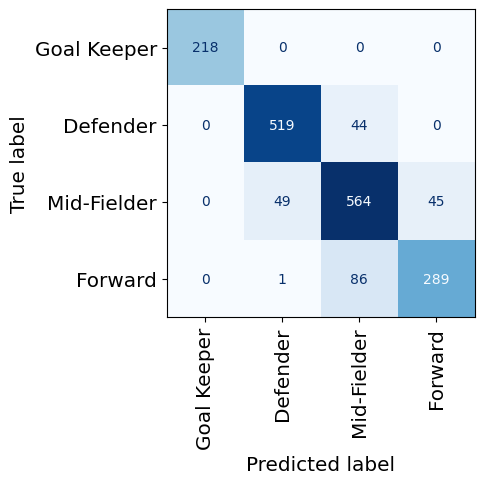

In [25]:
cm  = confusion_matrix(y_test.argmax(axis = 1), predict_y.data.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

plt.show();

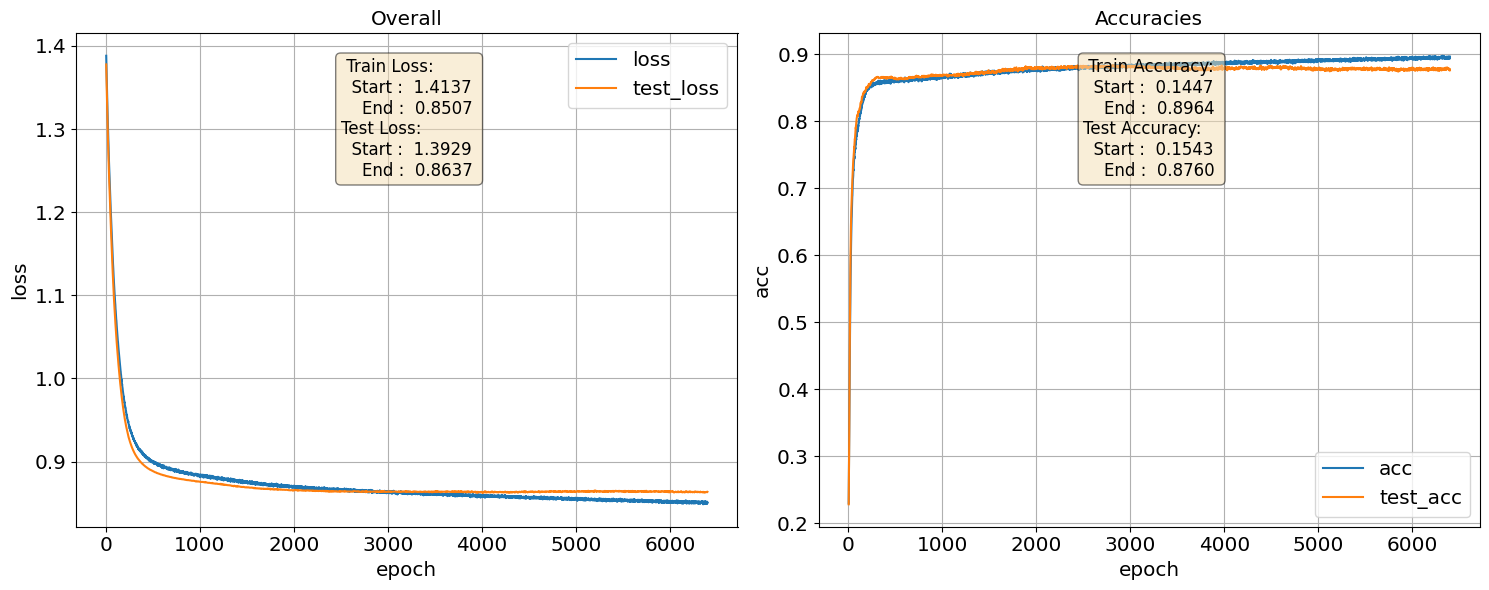

In [26]:
fig, axes = plt.subplots(1,2 , figsize = (15,6),)

l_range = 5 # ignoring first few records
x_var = 'epoch'
y1_var = 'loss'
y2_var = 'test_loss'

ax = axes[0]

loss_df[l_range:].plot(x = x_var, y = [y1_var, y2_var], ax = ax)

# get values for plotting
st_loss = loss_df[y1_var].iloc[0]
end_loss = loss_df[y1_var].iloc[-1]
t_st_loss = loss_df[y2_var].iloc[0]
t_end_loss = loss_df[y2_var].iloc[-1]

# little beautification
train_txtstr = "Train Loss: \n  Start : {:7.4f}\n    End : {:7.4f}".format( st_loss, end_loss )    # Train text to plot

test_txtstr = "Test Loss: \n  Start : {:7.4f}\n    End : {:7.4f}".format( t_st_loss, t_end_loss ) # Test text to plot
txtstr = ' {} \n{}'.format(train_txtstr, test_txtstr)
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax.set_xlabel(x_var)
ax.set_ylabel(y1_var)
ax.set_title('Overall')
ax.grid();

ax = axes[1]

y1_var = 'acc'
y2_var = 'test_acc'

loss_df[l_range:].plot(x = x_var, y = [y1_var, y2_var], ax = ax)

# get values for plotting
st_loss = loss_df[y1_var].iloc[0]
end_loss = loss_df[y1_var].iloc[-1]
t_st_loss = loss_df[y2_var].iloc[0]
t_end_loss = loss_df[y2_var].iloc[-1]

# little beautification
train_txtstr = "Train Accuracy: \n  Start : {:7.4f}\n    End : {:7.4f}".format( st_loss, end_loss )    # Train text to plot

test_txtstr = "Test Accuracy: \n  Start : {:7.4f}\n    End : {:7.4f}".format( t_st_loss, t_end_loss ) # Test text to plot# properties  matplotlib.patch.Patch 
txtstr = ' {} \n{}'.format(train_txtstr, test_txtstr)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax.set_xlabel(x_var)
ax.set_ylabel(y1_var)
ax.set_title('Accuracies'.format(l_range))
ax.grid();
plt.tight_layout()

In [27]:
loss_df[loss_df['test_loss'] == loss_df['test_loss'].min()]

,epoch,loss,test_loss,acc,test_acc
3947,3947,0.860044,0.862511,0.887583,0.881543
